In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
X_all = df[[feat for feat in df.columns if feat != "Diabetes_binary"]]
Y_all = df["Diabetes_binary"]

[Text(0, 0, '218334'), Text(0, 0, '35346')]

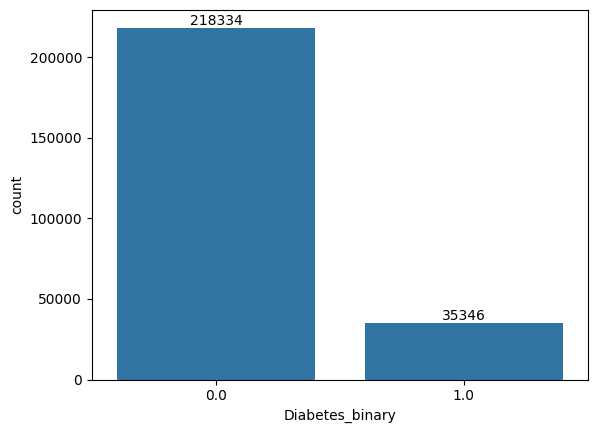

In [4]:
ax=sns.countplot(data=df, x="Diabetes_binary")
ax.bar_label(ax.containers[0])

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# Dados reservados para validação final do modelo
X, X_test, Y, y_test = train_test_split(X_all, Y_all, test_size=0.1, random_state=416, stratify=Y_all)

[Text(0, 0, '196501'), Text(0, 0, '31811')]

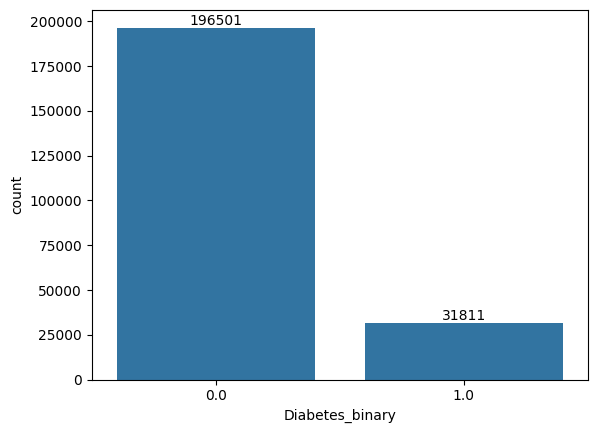

In [7]:
ax=sns.countplot(data=df.iloc[Y.index], x="Diabetes_binary")
ax.bar_label(ax.containers[0])

In [6]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV


Fazendo testes de mudanças de parâmetros com auxílio de GridSearch

In [18]:
parameters = {'n_estimators':(50, 100, 200), 'boosting_type': ("gbdt","dart", "rf"), "max_depth": (5,10,20,-1), "learning_rate": (0.1, 0.01), 
              "num_leaves":(50, 100, 150)}

In [19]:
classifier = LGBMClassifier(class_weight="balanced", objective="binary", verbose=-1)
gridsearch = GridSearchCV(classifier, parameters, cv=5, n_jobs=8, scoring="f1", verbose=0)
gridsearch.fit(X, Y)

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/

GridSearchCV(cv=5,
             estimator=LGBMClassifier(class_weight='balanced',
                                      objective='binary', verbose=-1),
             n_jobs=8,
             param_grid={'boosting_type': ('gbdt', 'dart', 'rf'),
                         'learning_rate': (0.1, 0.01),
                         'max_depth': (5, 10, 20, -1),
                         'n_estimators': (50, 100, 200),
                         'num_leaves': (50, 100, 150)},
             scoring='f1')

In [20]:
pd.DataFrame(gridsearch.cv_results_).sort_values(by=["mean_test_score"], ascending=False,).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
26,18.774415,0.211752,0.130824,0.023405,gbdt,0.1,20,200,150,"{'boosting_type': 'gbdt', 'learning_rate': 0.1...",0.446283,0.453223,0.449390,0.449872,0.440135,0.447781,0.004411,1
35,20.667922,1.333793,0.145454,0.016238,gbdt,0.1,-1,200,150,"{'boosting_type': 'gbdt', 'learning_rate': 0.1...",0.446372,0.454110,0.447444,0.447784,0.439474,0.447037,0.004656,2
25,12.844120,0.065552,0.120441,0.013183,gbdt,0.1,20,200,100,"{'boosting_type': 'gbdt', 'learning_rate': 0.1...",0.445754,0.451019,0.447903,0.449668,0.440517,0.446972,0.003679,3
34,12.845049,0.053340,0.108046,0.004824,gbdt,0.1,-1,200,100,"{'boosting_type': 'gbdt', 'learning_rate': 0.1...",0.448129,0.452583,0.446590,0.447832,0.439594,0.446946,0.004199,4
17,17.192925,0.343362,0.154075,0.028722,gbdt,0.1,10,200,150,"{'boosting_type': 'gbdt', 'learning_rate': 0.1...",0.446237,0.452122,0.447711,0.449805,0.437381,0.446651,0.005042,5


Avaliando cutoff ótimo

In [22]:
from tqdm import tqdm
from sklearn.metrics import f1_score, matthews_corrcoef, roc_curve, roc_auc_score, \
                            classification_report ,confusion_matrix,balanced_accuracy_score, recall_score, precision_score, precision_recall_curve

In [23]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

In [23]:
mccs, balan_accs, f1s, cms = [],[],[], []
tprs, fprs, aucs = [], [], []
mean_fpr = np.linspace(0, 1, 100)
for i in tqdm(range(1,101)):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    clf = LGBMClassifier(class_weight="balanced", objective="binary", verbose=-1, max_depth=20, n_estimators=200, num_leaves=150)
    clf.fit(X_train, Y_train)
    y_pred_prob = clf.predict_proba(X_val)
    y_pred = to_labels(y_pred_prob, 0.5)[:, 1]
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    f1s.append(f1)
    cms.append(confusion_matrix(Y_val, y_pred))
    fpr, tpr, thresholds = roc_curve(Y_val, y_pred_prob[:, 1], pos_label=1, drop_intermediate=True)
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr); #fprs.append(fpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████| 100/100 [05:55<00:00,  3.55s/it]


In [24]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")

ACC Balanceada: 0.7435 +- 0.0019
ROC-AUC: 0.8221 +- 0.0017
MCC: 0.3604 +- 0.0027
F1: 0.4470 +- 0.0020


<Axes: >

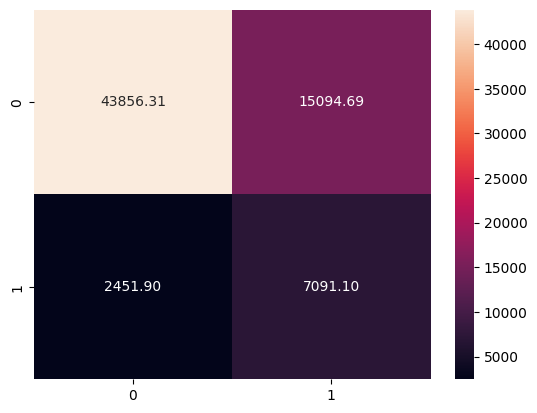

In [25]:
cms = np.array(cms)

sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")

<Figure size 640x480 with 0 Axes>

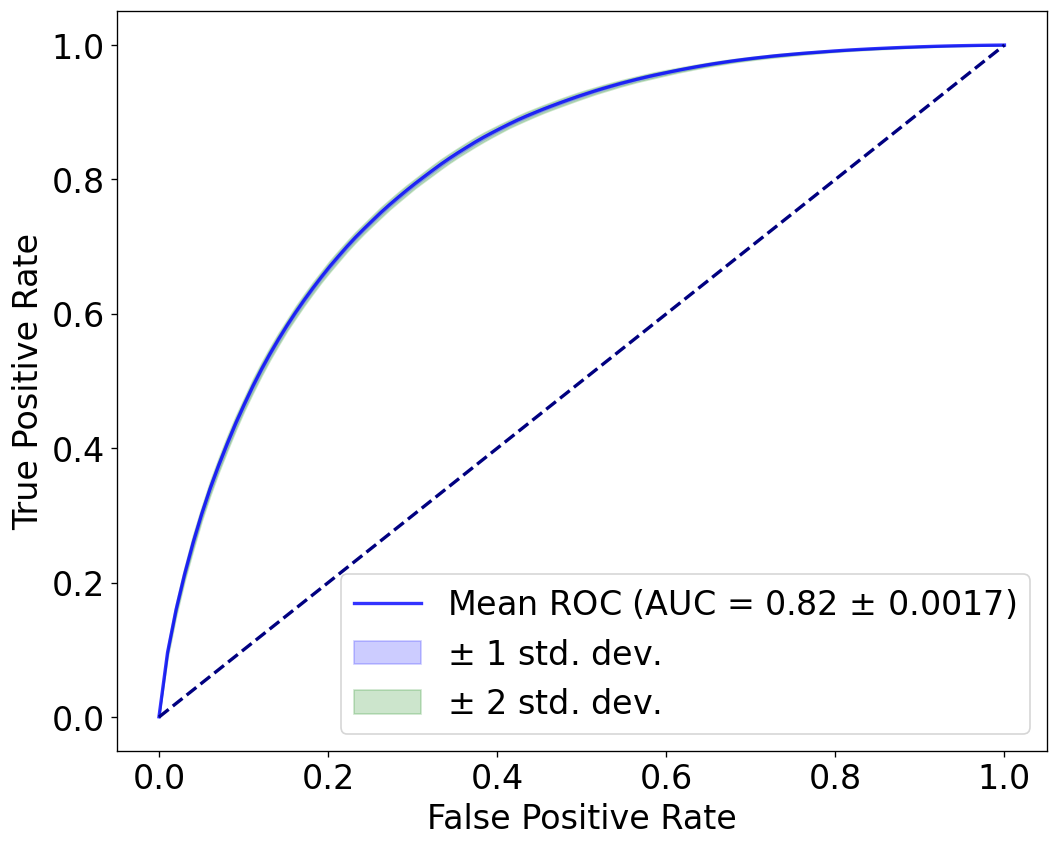

In [27]:
plt.figure()
# plt.style.use('seaborn-whitegrid')

lw = 2
plt.figure(figsize=(10, 8), dpi=120)

mean_tpr = np.mean(np.array(tprs), axis=0)
mean_fpr = np.linspace(0, 1, 100)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.4f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="blue",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr*2, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr*2, 0)

plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="green",
    alpha=0.2,
    label=r"$\pm$ 2 std. dev.",
)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("False Positive Rate", fontsize=20)
plt.ylabel("True Positive Rate", fontsize=20)
# plt.title("Curva ROC", fontsize=20)
plt.legend(loc="lower right",prop={'size': 20})

Avaliando cutoff ótimocom f1-score

In [29]:
thresholds = np.arange(0, 1, 0.01)
melhores_thresholds = []
mccs, balan_accs, f1s, cms = [],[],[], []
tprs, fprs, aucs = [], [], []
mean_fpr = np.linspace(0, 1, 100)
for i in tqdm(range(1,101)):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    clf = LGBMClassifier(class_weight="balanced", objective="binary", verbose=-1, max_depth=20, n_estimators=200, num_leaves=150)
    clf.fit(X_train, Y_train)
    y_pred_proba_train = clf.predict_proba(X_train)
    scores = [f1_score(Y_train, to_labels(y_pred_proba_train, t)[:, 1]) for t in thresholds]
    melhor_treshold = np.array(scores).argmax()
    melhores_thresholds.append(thresholds[melhor_treshold])
    y_pred_prob = clf.predict_proba(X_val)
    y_pred = to_labels(y_pred_prob, thresholds[melhor_treshold])[:, 1]
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    f1s.append(f1)
    cms.append(confusion_matrix(Y_val, y_pred))
    fpr, tpr, thresholds_ = roc_curve(Y_val, y_pred_prob[:, 1], pos_label=1, drop_intermediate=True)
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr); #fprs.append(fpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████| 100/100 [14:41<00:00,  8.81s/it]


In [30]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")

ACC Balanceada: 0.6997 +- 0.0046
ROC-AUC: 0.8221 +- 0.0017
MCC: 0.3606 +- 0.0040
F1: 0.4573 +- 0.0037


In [32]:
print(f"Média do ponto de corte ótimo: {np.mean(melhores_thresholds)}")

Média do ponto de corte ótimo: 0.6774000000000001


<Axes: >

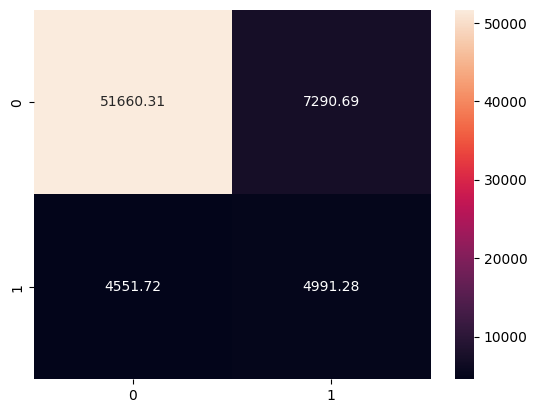

In [31]:
cms = np.array(cms)

sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")

In [13]:
thresholds = np.arange(0, 1, 0.01)
melhores_thresholds = []
mccs, balan_accs, f1s, cms = [],[],[], []
tprs, fprs, aucs = [], [], []
mean_fpr = np.linspace(0, 1, 100)
for i in tqdm(range(1,101)):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    clf = LGBMClassifier(class_weight="balanced", objective="binary", verbose=-1, max_depth=20, n_estimators=200, num_leaves=150)
    clf.fit(X_train, Y_train)
    # y_pred_proba_train = clf.predict_proba(X_train)
    y_pred_prob = clf.predict_proba(X_val)
    scores = [balanced_accuracy_score(Y_val, to_labels(y_pred_prob, t)[:, 1]) for t in thresholds]
    melhor_treshold = np.array(scores).argmax()
    melhores_thresholds.append(thresholds[melhor_treshold])
    
    y_pred = to_labels(y_pred_prob, thresholds[melhor_treshold])[:, 1]
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    f1s.append(f1)
    cms.append(confusion_matrix(Y_val, y_pred))
    fpr, tpr, thresholds_ = roc_curve(Y_val, y_pred_prob[:, 1], pos_label=1, drop_intermediate=True)
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr); #fprs.append(fpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████| 100/100 [10:47<00:00,  6.47s/it]


In [10]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")

ACC Balanceada: 0.7420 +- 0.0021
ROC-AUC: 0.8221 +- 0.0017
MCC: 0.3626 +- 0.0029
F1: 0.4508 +- 0.0027


In [14]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")

ACC Balanceada: 0.7460 +- 0.0017
ROC-AUC: 0.8221 +- 0.0017
MCC: 0.3537 +- 0.0041
F1: 0.4351 +- 0.0052


In [11]:
print(f"Média do ponto de corte ótimo: {np.mean(melhores_thresholds)}")

Média do ponto de corte ótimo: 0.5172999999999999


In [21]:
print(f"Média do ponto de corte ótimo: {np.mean(melhores_thresholds)} +- {np.std(melhores_thresholds)}")

Média do ponto de corte ótimo: 0.4472 +- 0.020788458336298055


<Axes: >

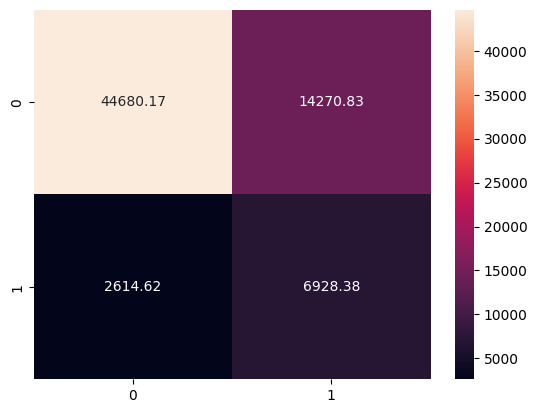

In [12]:
cms = np.array(cms)

sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")

<Axes: >

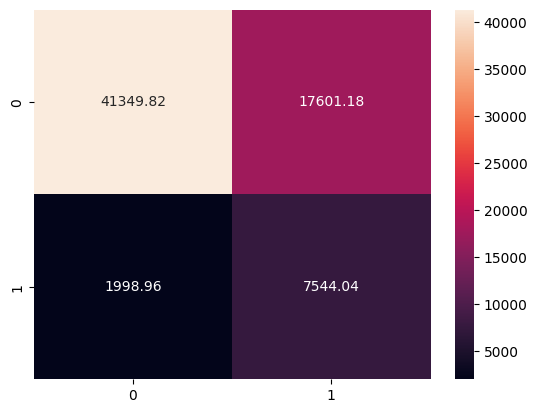

In [16]:
cms = np.array(cms)

sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")